<a href="https://colab.research.google.com/github/DreamTeamInc/Core-DS/blob/issues%2F1/Core_EDA_Andrew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from google.colab import drive
drive.mount('/content/drive')

# Path to 'sample_core_analysis_data_example' folder with folder name
path_to_data = 'drive/My Drive/ sample_core_analysis_data_example'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initializing packages

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2 as cv
import seaborn as sns

from PIL import Image
from skimage import exposure
from skimage import io

import sklearn
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In [73]:
data = pd.read_csv(path_to_data + '/data.csv')
data

,task_id,photo_id,photo_type,segment_num,segment_type,segment_value
0,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,0,Свечение,Насыщенное
1,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,1,Свечение,Отсутствует
2,cfb8e7b2_7c98_4bd4_897d_0e5e95801bc9,1016625,УФ,0,Свечение,Карбонатное
3,a9d8f546_9046_46ce_ba17_abda344a0980,1013361,УФ,0,Свечение,Карбонатное
4,eb09a8aa_6c77_41de_8489_f5a390c789e8,1016727,УФ,0,Свечение,Карбонатное
...,...,...,...,...,...,...
14910,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,6,Разрушенность,Разлом
14911,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,7,Разрушенность,Разлом
14912,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,8,Разрушенность,Разлом
14913,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,9,Разрушенность,Разлом


In [74]:
print(pd.unique(data['segment_value'].values))

['Насыщенное' 'Отсутствует' 'Карбонатное' 'Разлом' 'Аргиллит'
 'Переслаивание пород' 'Алевролит глинистый' 'Песчаник' 'Проба'
 'Глинисто-кремнистая порода' 'Песчаник глинистый' 'Уголь'
 'Аргиллит углистый' 'Алевролит' 'Карбонатная порода' 'Известняк'
 'Глина аргиллитоподобная']


In [75]:
print('Классификация сегментов', pd.unique(data['segment_type'].values))

Классификация сегментов ['Свечение' 'Разрушенность' 'Порода']


In [76]:
print('Свечение - ', pd.unique(data[data['segment_type'] == 'Свечение']['segment_value'].values))
print('Разрушенность - ', pd.unique(data[data['segment_type'] == 'Разрушенность']['segment_value'].values))
print('Порода - ', pd.unique(data[data['segment_type'] == 'Порода']['segment_value'].values))

Свечение -  ['Насыщенное' 'Отсутствует' 'Карбонатное']
Разрушенность -  ['Разлом' 'Проба']
Порода -  ['Аргиллит' 'Переслаивание пород' 'Алевролит глинистый' 'Песчаник'
 'Глинисто-кремнистая порода' 'Песчаник глинистый' 'Уголь'
 'Аргиллит углистый' 'Алевролит' 'Карбонатная порода' 'Известняк'
 'Глина аргиллитоподобная']


# **Functions for getting data** 

In [77]:
def get_photo(data,i):
  return io.imread(path_to_data + '/photos/{}.jpeg'.format(data['photo_id'][i]))

def get_photo_by_id(data,id):
  return io.imread(path_to_data + '/photos/{}.jpeg'.format(id))

def get_mask(data, i):
    return np.load(path_to_data + '/matrixes/matrix_{}__{}.npz'.format(data['photo_id'][i], data['task_id'][i]))['data']

def get_json(data,i):
  with open(path_to_data + '/extra/extra_{}__{}.json'.format(data['photo_id'][i],data['task_id'][i])) as json_data:
    d = json.load(json_data)
    json_data.close()
  return d

## **Functions for displaying data**


In [78]:
def show_image(image,nrows=1,ncols=1,cmap='gray'):
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
  ax.imshow(image)
  ax.axis('off')
  return fig, ax

def show_all_photo_data(data,i):
  print(data.iloc[i])
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
  ax1.imshow(get_photo(data, i))
  
  mask = get_mask(data,i)
  cmap = plt.get_cmap('tab20b', np.max(mask) + 1)
  mask = ax2.imshow(mask, cmap=cmap,vmin=-0.5, vmax=np.max(get_mask(data, i))+0.5)
  ax2.axis('off')
  fig.colorbar(mask, ticks=np.arange(0, np.max(get_mask(data, i))+1))
  return fig, (ax1, ax2)

def show_photo_series(data, column, value):
    fig, ax_ar = plt.subplots(1, 10, figsize=(14, 14))
    filt_data = data[data[column] == value]
    i = np.random.randint(0, filt_data.shape[0])
    for ax in ax_ar:
        filt_by_photo = filt_data[filt_data['photo_id'] == filt_data['photo_id'].iloc[i]]
        segments = filt_by_photo['segment_num'].values
        photo = get_photo(data, filt_by_photo.index.values[0])
        mask = get_mask(data, filt_by_photo.index.values[0])
        for value in segments:
            mask = np.ma.masked_where(mask == value, mask)
        
        ax.imshow(photo)
        ax.imshow(mask)
        ax.axis('off')
        filt_data.drop(filt_by_photo.index.values, axis=0, inplace=True)
        i = np.random.randint(0, filt_data.shape[0])
    
    return fig, ax_ar

task_id          4a1fa29c_aa61_4ef7_9510_61c01a998a9e
photo_id                                      1005130
photo_type                                         ДС
segment_num                                        37
segment_type                            Разрушенность
segment_value                                  Разлом
Name: 1000, dtype: object


(<Figure size 720x720 with 3 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f5d2a21fcf8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f5d2a0b6b70>))

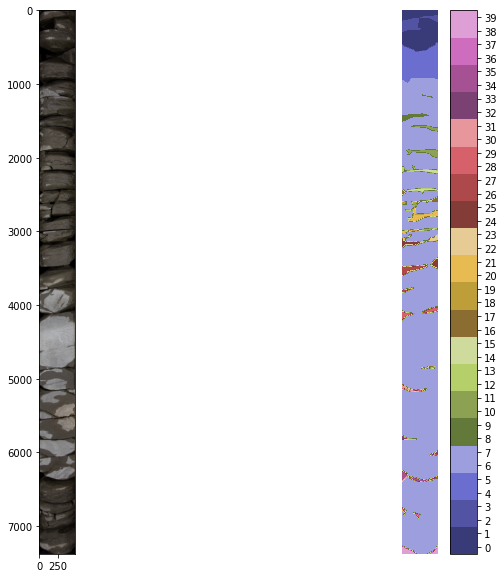

In [ ]:
show_all_photo_data(data,1000)

# **Data categorization**

In [ ]:
df = pd.DataFrame(0,index=np.array(range(1, 2061)),
                  columns=np.array(range(1, 21)))

In [ ]:
df = df.rename(columns = {1:'photo_id',2:'УФ',3:'ДС',4:'Насыщенное',5:'Отсутствует',6:'Карбонатное',7:'Разлом',8:'Проба',
                     9:'Аргиллит',10:'Переслаивание пород',11:'Алевролит глинистый',12:'Песчаник',13:'Глинисто-кремнистая порода',14:'Песчаник глинистый',
                     15:'Уголь',16:'Аргиллит углистый',17:'Алевролит',18:'Карбонатная порода',19:'Известняк',20:'Глина аргиллитоподобная'})

df['photo_id'] = data['photo_id'].unique()

In [ ]:
data[data['segment_value'] == 'Аргиллит'].shape

(757, 6)

In [ ]:
def categorical_features_transform(data,df,column_name):
  for pi in df['photo_id'].tolist():
    d = data[data['photo_id'] == pi]
    for value in d[column_name].values:
      df.loc[df['photo_id'] == pi,value] = 1
  return df

In [ ]:
df = categorical_features_transform(data,df,'photo_type')
df = categorical_features_transform(data,df,'segment_value')

df.to_csv('data_categorization.csv', index=False, header=False)

In [ ]:
df

,photo_id,УФ,ДС,Насыщенное,Отсутствует,Карбонатное,Разлом,Проба,Аргиллит,Переслаивание пород,Алевролит глинистый,Песчаник,Глинисто-кремнистая порода,Песчаник глинистый,Уголь,Аргиллит углистый,Алевролит,Карбонатная порода,Известняк,Глина аргиллитоподобная
1,1012473,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1016625,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1013361,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1016727,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1003985,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,1012723,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2057,1003764,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
2058,1002852,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2059,1009408,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0


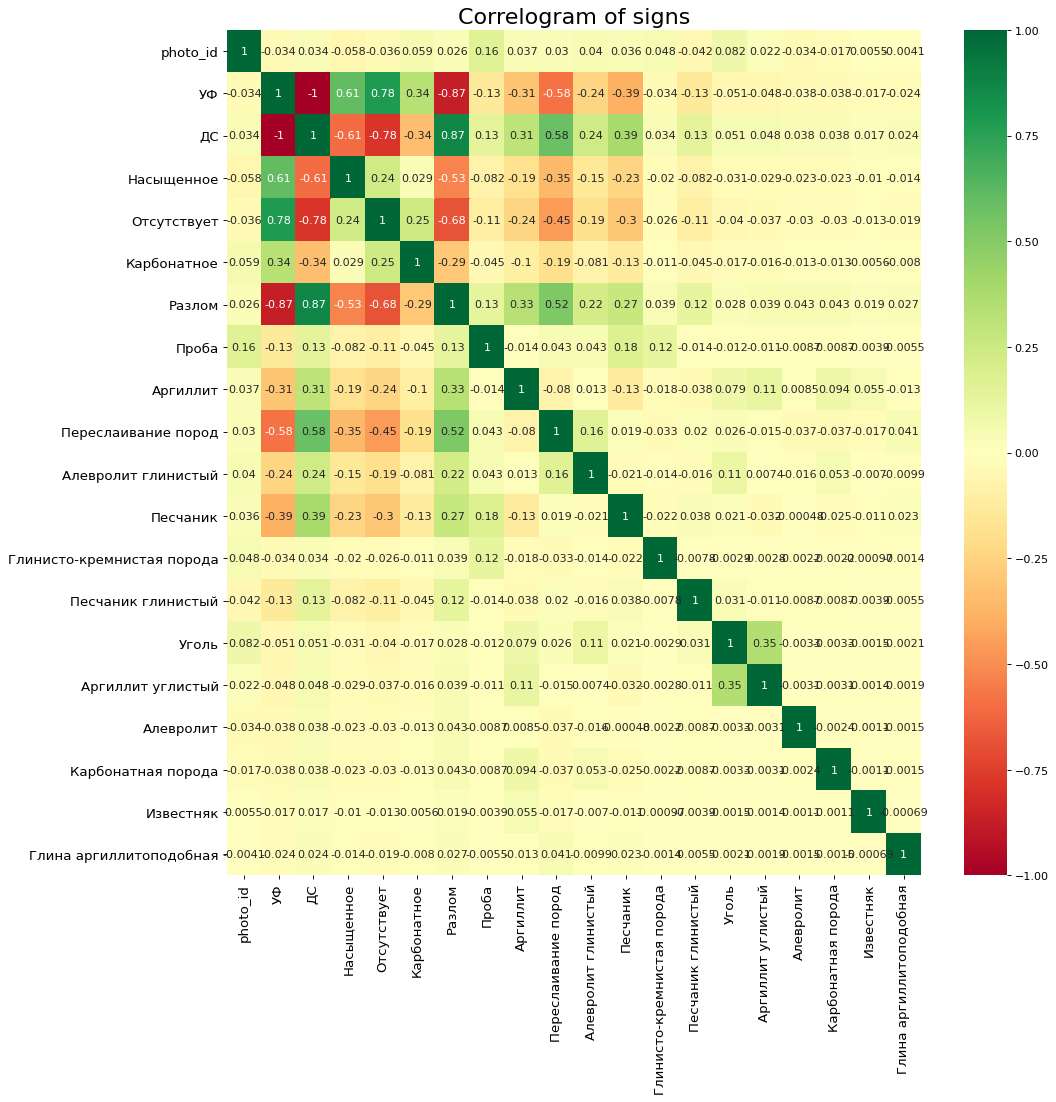

In [ ]:
plt.figure(figsize = (14,14),dpi = 80)
sns.heatmap(df.corr(),xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Correlogram of signs',fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.savefig('heatmap.png')

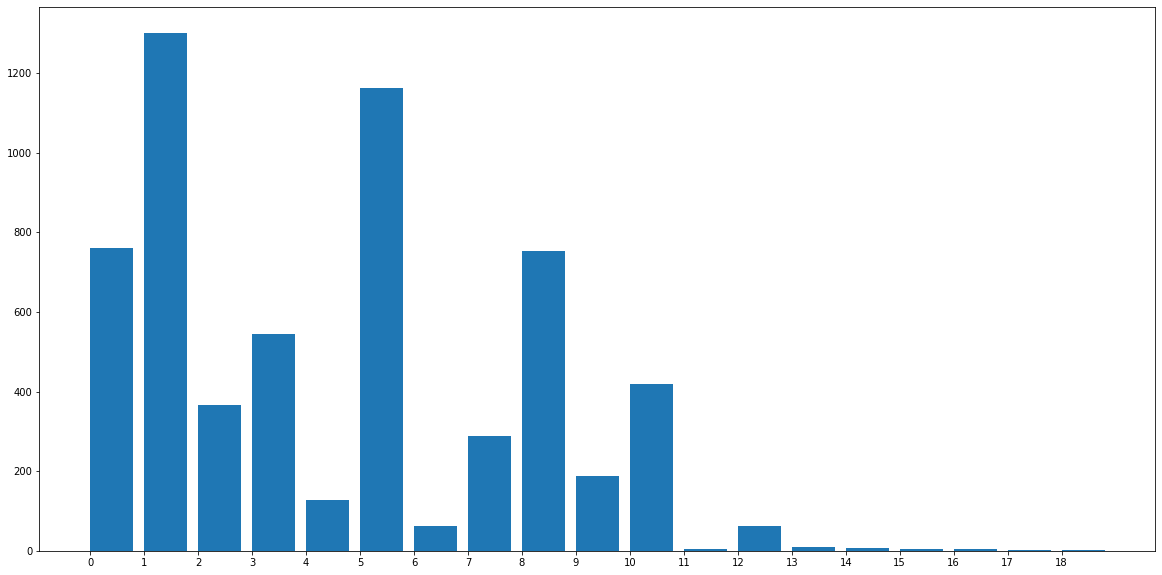

In [ ]:
sum = []
for value in df.columns:
  if value != 'photo_id':
    sum.append(df[value].sum())
  x = range(len(sum))
fig, ax = plt.subplots()
ax.bar(x, sum, align='edge')
fig.set_figwidth(20)
fig.set_figheight(10)
ax.set_xticks(x)
plt.show()

## **Analysis of pictures in ultraviolet**

In [ ]:
uv_data = data=data[data['photo_type'] == 'УФ']

In [87]:
uv_data.reset_index(inplace = True, drop = True)
uv_data = uv_data.assign(hog_features = 0)
uv_data

,task_id,photo_id,photo_type,segment_num,segment_type,segment_value,hog_features
0,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,0,Свечение,Насыщенное,0
1,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,1,Свечение,Отсутствует,0
2,cfb8e7b2_7c98_4bd4_897d_0e5e95801bc9,1016625,УФ,0,Свечение,Карбонатное,0
3,a9d8f546_9046_46ce_ba17_abda344a0980,1013361,УФ,0,Свечение,Карбонатное,0
4,eb09a8aa_6c77_41de_8489_f5a390c789e8,1016727,УФ,0,Свечение,Карбонатное,0
...,...,...,...,...,...,...,...
1800,e278565e_1174_4b2a_8d7e_00a6622ce755,1007705,УФ,11,Свечение,Насыщенное,0
1801,e278565e_1174_4b2a_8d7e_00a6622ce755,1007705,УФ,12,Свечение,Отсутствует,0
1802,f9acac88_f3fb_4307_ba52_39f5ed061ea7,1002269,УФ,0,Свечение,Насыщенное,0
1803,d204752f_d975_4bf7_a124_7fae92ac81ca,1012723,УФ,0,Свечение,Карбонатное,0


In [ ]:
from skimage.feature import hog
from skimage.color import rgb2gray


for i in range(uv_data.shape[0]):
  segment_num = uv_data['segment_num'].iloc[i]
  part_of_photo = np.ma.masked_where(get_mask(uv_data,i) == segment_num, rgb2gray(get_photo(uv_data,i)))
  hist = np.histogram(part_of_photo.mask * part_of_photo.data, bins = 64, range = (0,1))
  uv_data['hog_features'].iloc[i] = np.array(hist[0][1:] / np.sum(part_of_photo.mask),dtype=object)

In [101]:
uv_data.to_csv('uv_data_with_segments_feature.csv', index=False, header=False)

In [102]:
uv_data

,task_id,photo_id,photo_type,segment_num,segment_type,segment_value,hog_features
0,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,0,Свечение,Насыщенное,"[0.10857571039172742, 0.1018939315545286, 0.10..."
1,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,1,Свечение,Отсутствует,"[0.2857091726153785, 0.04385774790718021, 0.01..."
2,cfb8e7b2_7c98_4bd4_897d_0e5e95801bc9,1016625,УФ,0,Свечение,Карбонатное,"[0.0011858234567626862, 0.0009531489747128647,..."
3,a9d8f546_9046_46ce_ba17_abda344a0980,1013361,УФ,0,Свечение,Карбонатное,"[0.0012814979277617343, 0.01060870838652047, 0..."
4,eb09a8aa_6c77_41de_8489_f5a390c789e8,1016727,УФ,0,Свечение,Карбонатное,"[0.0009363193441570756, 0.000987374731959214, ..."
...,...,...,...,...,...,...,...
1800,e278565e_1174_4b2a_8d7e_00a6622ce755,1007705,УФ,11,Свечение,Насыщенное,"[0.13471962244524355, 0.03835793759281987, 0.0..."
1801,e278565e_1174_4b2a_8d7e_00a6622ce755,1007705,УФ,12,Свечение,Отсутствует,"[0.08587749593480695, 0.015656265083389177, 0...."
1802,f9acac88_f3fb_4307_ba52_39f5ed061ea7,1002269,УФ,0,Свечение,Насыщенное,"[0.0, 5.900013624773731e-05, 7.116511279366254..."
1803,d204752f_d975_4bf7_a124_7fae92ac81ca,1012723,УФ,0,Свечение,Карбонатное,"[0.14038542659026385, 0.37877155938517537, 0.2..."


In [210]:
train_data = pd.DataFrame(data=0,columns = range(uv_data['hog_features'][0].shape[0] + 1),index=range(1805))

In [211]:
for i in range(train_data.shape[0]):
  for k in range(uv_data['hog_features'][0].shape[0]):
    train_data[k].loc[i] = uv_data['hog_features'][i][k]
  train_data[63].loc[i] = uv_data['segment_value'].loc[i]

In [181]:
train_data.to_csv('train_data_features.csv', index=False, header=False)

In [213]:
y = train_data[63]
train_data.drop([63],axis='columns', inplace=True)

In [214]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split


classifier = svm.SVC()
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.3, shuffle=False)

classifier.fit(X_train,y_train)
predicted = classifier.predict(X_test)


In [220]:
sklearn.metrics.accuracy_score(y_test,predicted)

0.8468634686346863

In [222]:
sklearn.metrics.f1_score(y_test,predicted, average='macro')

0.7157272599980934